In [62]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [63]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [64]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [65]:
setup_seed()

<IPython.core.display.Javascript object>

In [66]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [67]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## Houses prices : loading data

In [7]:
dataset_name = "kaggle-house-prices"
out = Path(os.getcwd() + "/data/" + dataset_name + "-train.csv")

target = "SalePrice"
to_remove = []
train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [8]:
!ls data

census-income.csv	forest-cover-type.zip	       wine-quality.csv
census-income_test.csv	kaggle-house-prices-test.csv
forest-cover-type.csv	kaggle-house-prices-train.csv


<IPython.core.display.Javascript object>

In [9]:
train.shape

(1460, 81)

<IPython.core.display.Javascript object>

In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<IPython.core.display.Javascript object>

In [11]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0])
        )
    )
    train_index, valid_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>

In [12]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [13]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'CentralAir', 'Utilities', 'Street'],
 'num_cols': ['GarageYrBlt',
  'ScreenPorch',
  'GrLivArea',
  'MasVnrArea',
  'LotArea',
  'BsmtUnfSF',
  'EnclosedPorch',
  'YearRemodAdd',
  'BsmtFinSF2',
  'YearBuilt',
  'WoodDeckSF',
  'BsmtFinSF1',
  '1stFlrSF',
  'TotalBsmtSF',
  'GarageArea',
  '2ndFlrSF',
  'OpenPorchSF',
  'Id',
  'LotFrontage'],
 'cat_cols': ['KitchenAbvGr',
  'GarageCond',
  'LandSlope',
  'Exterior1st',
  'Functional',
  'SaleType',
  'BsmtQual',
  'Electrical',
  'Fireplaces',
  'FullBath',
  'OverallCond',
  'RoofStyle',
  'PavedDrive',
  'BsmtCond',
  'BsmtFinType1',
  'GarageCars',
  'MiscVal',
  'TotRmsAbvGrd',
  'LowQualFinSF',
  'HalfBath',
  'Heating',
  'LotShape',
  'KitchenQual',
  'MasVnrType',
  'PoolQC',
  'Foundation',
  'BedroomAbvGr',
  'RoofMatl',
  '3SsnPorch',
  'GarageType',
  'BsmtFinType2',
  'Condition1',
  'OverallQual',
  'BsmtExposure',
  'ExterQual',
  'MSSubClass',
  'YrSold',
  'LandContour',


<IPython.core.display.Javascript object>

In [14]:
len(train_indices)

1219

<IPython.core.display.Javascript object>

In [15]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [16]:
target_encoder = StandardScaler()

<IPython.core.display.Javascript object>

In [17]:
target_encoder.fit(train[target].values.reshape(-1, 1))
y_train = target_encoder.transform(train[target].values[train_indices].reshape(-1, 1))
y_valid = target_encoder.transform(train[target].values[valid_indices].reshape(-1, 1))
y_test = target_encoder.transform(train[target].values[test_indices].reshape(-1, 1))

<IPython.core.display.Javascript object>

In [18]:
params

{'constant_cols': [],
 'bool_cols': ['Alley', 'CentralAir', 'Utilities', 'Street'],
 'num_cols': ['GarageYrBlt',
  'ScreenPorch',
  'GrLivArea',
  'MasVnrArea',
  'LotArea',
  'BsmtUnfSF',
  'EnclosedPorch',
  'YearRemodAdd',
  'BsmtFinSF2',
  'YearBuilt',
  'WoodDeckSF',
  'BsmtFinSF1',
  '1stFlrSF',
  'TotalBsmtSF',
  'GarageArea',
  '2ndFlrSF',
  'OpenPorchSF',
  'Id',
  'LotFrontage'],
 'cat_cols': ['KitchenAbvGr',
  'GarageCond',
  'LandSlope',
  'Exterior1st',
  'Functional',
  'SaleType',
  'BsmtQual',
  'Electrical',
  'Fireplaces',
  'FullBath',
  'OverallCond',
  'RoofStyle',
  'PavedDrive',
  'BsmtCond',
  'BsmtFinType1',
  'GarageCars',
  'MiscVal',
  'TotRmsAbvGrd',
  'LowQualFinSF',
  'HalfBath',
  'Heating',
  'LotShape',
  'KitchenQual',
  'MasVnrType',
  'PoolQC',
  'Foundation',
  'BedroomAbvGr',
  'RoofMatl',
  '3SsnPorch',
  'GarageType',
  'BsmtFinType2',
  'Condition1',
  'OverallQual',
  'BsmtExposure',
  'ExterQual',
  'MSSubClass',
  'YrSold',
  'LandContour',


<IPython.core.display.Javascript object>

In [19]:
model = build_model(
    params,
    lconv_dim=[4],
    lconv_num_dim=[8],
    emb_size=16,
    # For this problem, we need "tanh" as first layer, or else to standard scale the data beforehand
    activation_num_first_layer=None,  # "tanh",
    output_activation=None,
    output_dim=1,  # np.unique(y_train).shape[0],
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [20]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_num (InputLayer)          [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_cat (InputLayer)          [(None, 57)]         0                                            
__________________________________________________________________________________________________
reshape_num_input (Reshape)     (None, 19, 1)        0           input_num[0][0]                  
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 57, 16)       432         input_cat[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [21]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

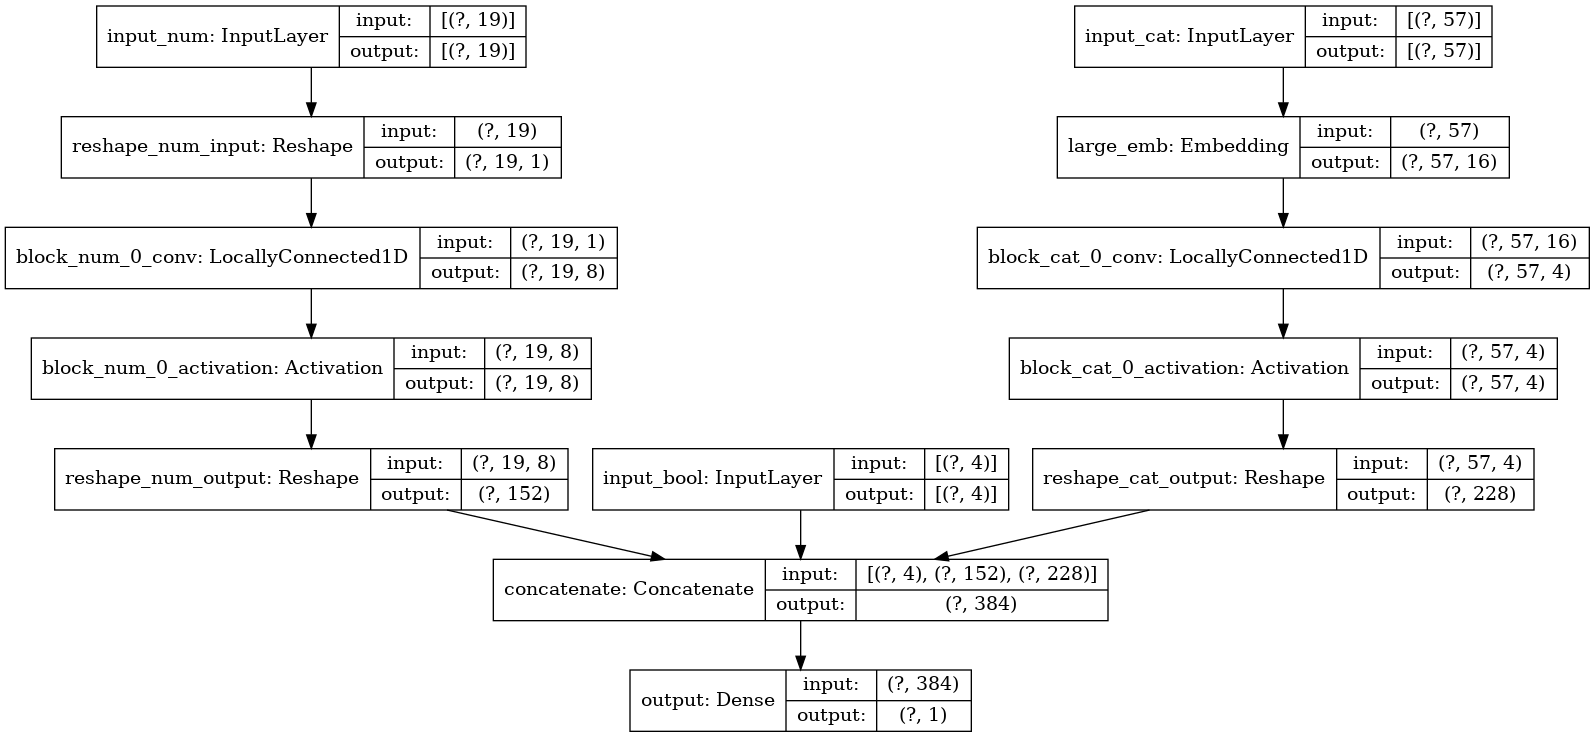

<IPython.core.display.Javascript object>

In [22]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [23]:
y_train.shape

(1219, 1)

<IPython.core.display.Javascript object>

In [24]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [25]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=8,
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, verbose=1)],
    #class_weight=None#class_weight
)

Epoch 1/2000
153/153 - 0s - loss: 0.9550 - val_loss: 0.9741
Epoch 2/2000
153/153 - 0s - loss: 0.8087 - val_loss: 0.7659
Epoch 3/2000
153/153 - 0s - loss: 0.5667 - val_loss: 0.4699
Epoch 4/2000
153/153 - 0s - loss: 0.3263 - val_loss: 0.3461
Epoch 5/2000
153/153 - 0s - loss: 0.2323 - val_loss: 0.3441
Epoch 6/2000
153/153 - 0s - loss: 0.1912 - val_loss: 0.3608
Epoch 7/2000
153/153 - 0s - loss: 0.1656 - val_loss: 0.3830
Epoch 8/2000
153/153 - 0s - loss: 0.1469 - val_loss: 0.4009
Epoch 9/2000
153/153 - 0s - loss: 0.1350 - val_loss: 0.4054
Epoch 10/2000
153/153 - 0s - loss: 0.1280 - val_loss: 0.4071
Epoch 11/2000
153/153 - 0s - loss: 0.1208 - val_loss: 0.4271
Epoch 12/2000
153/153 - 0s - loss: 0.1153 - val_loss: 0.4263
Epoch 13/2000
153/153 - 0s - loss: 0.1106 - val_loss: 0.4319
Epoch 14/2000
153/153 - 0s - loss: 0.1074 - val_loss: 0.4239
Epoch 15/2000
153/153 - 0s - loss: 0.1040 - val_loss: 0.4496
Epoch 00015: early stopping
CPU times: user 9.25 s, sys: 1.09 s, total: 10.3 s
Wall time: 4.19

<IPython.core.display.Javascript object>

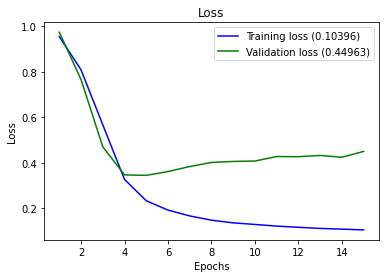

<IPython.core.display.Javascript object>

In [26]:
plot_history(history)

In [27]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

20578.157648026317

<IPython.core.display.Javascript object>

In [29]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
np.sqrt(model_auc)

53251.76449192724

<IPython.core.display.Javascript object>

In [30]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

17945.28162457192

<IPython.core.display.Javascript object>

In [31]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
np.sqrt(model_auc)

32207.946240018537

<IPython.core.display.Javascript object>

In [32]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [33]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [34]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [35]:
y_test.shape

(146, 1)

<IPython.core.display.Javascript object>

In [36]:
encoded_output.shape

(146, 384)

<IPython.core.display.Javascript object>

In [37]:
explanations.shape

(146, 80)

<IPython.core.display.Javascript object>

In [38]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [39]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['Alley', 'CentralAir', 'Utilities', 'Street', 'GarageYrBlt',
       'ScreenPorch', 'GrLivArea', 'MasVnrArea', 'LotArea', 'BsmtUnfSF',
       'EnclosedPorch', 'YearRemodAdd', 'BsmtFinSF2', 'YearBuilt',
       'WoodDeckSF', 'BsmtFinSF1', '1stFlrSF', 'TotalBsmtSF',
       'GarageArea', '2ndFlrSF', 'OpenPorchSF', 'Id', 'LotFrontage',
       'KitchenAbvGr', 'GarageCond', 'LandSlope', 'Exterior1st',
       'Functional', 'SaleType', 'BsmtQual', 'Electrical', 'Fireplaces',
       'FullBath', 'OverallCond', 'RoofStyle', 'PavedDrive', 'BsmtCond',
       'BsmtFinType1', 'GarageCars', 'MiscVal', 'TotRmsAbvGrd',
       'LowQualFinSF', 'HalfBath', 'Heating', 'LotShape', 'KitchenQual',
       'MasVnrType', 'PoolQC', 'Foundation', 'BedroomAbvGr', 'RoofMatl',
       '3SsnPorch', 'GarageType', 'BsmtFinType2', 'Condition1',
       'OverallQual', 'BsmtExposure', 'ExterQual', 'MSSubClass', 'YrSold',
       'LandContour', 'LotConfig', 'Exterior2nd', 'MSZoning',
       'BsmtFullBath', 'GarageQual', 'B

<IPython.core.display.Javascript object>

## Explain global

In [40]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

In [41]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [42]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

In [43]:
global_explain

array([0.01213706, 0.01249512, 0.01247896, 0.01248778, 0.01249525,
       0.01248638, 0.01264312, 0.01249935, 0.01252395, 0.01248392,
       0.01247938, 0.01251382, 0.01247856, 0.01250105, 0.01250123,
       0.01254062, 0.01259676, 0.01261377, 0.01255267, 0.01253455,
       0.01250464, 0.01247408, 0.01249304, 0.01239312, 0.01244947,
       0.0125005 , 0.01249218, 0.01235729, 0.01256666, 0.01261219,
       0.01245679, 0.01254174, 0.01257154, 0.01245411, 0.01251785,
       0.01245228, 0.01242484, 0.01248275, 0.01262292, 0.01246693,
       0.01261781, 0.01246967, 0.01253725, 0.01247185, 0.01250996,
       0.01268043, 0.01247731, 0.01247935, 0.01250156, 0.01252856,
       0.01248502, 0.01248103, 0.012434  , 0.01247513, 0.01238534,
       0.01274625, 0.01263823, 0.01264046, 0.01244941, 0.01247696,
       0.01248453, 0.01251983, 0.01248647, 0.01244313, 0.01249484,
       0.01246867, 0.01229448, 0.01247532, 0.01247631, 0.01244779,
       0.01247146, 0.01246089, 0.01249842, 0.01248172, 0.01249

<IPython.core.display.Javascript object>

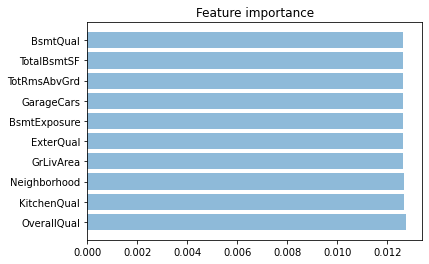

<IPython.core.display.Javascript object>

In [44]:
explain_plot(global_explain, all_cols)

## Explain local

In [45]:
# Looks like this is broken for now.

<IPython.core.display.Javascript object>

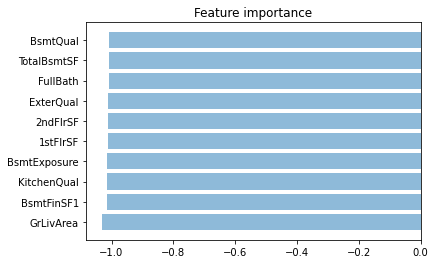

-0.6531246304512024


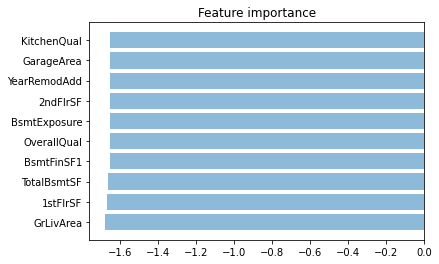

-1.4510325193405151


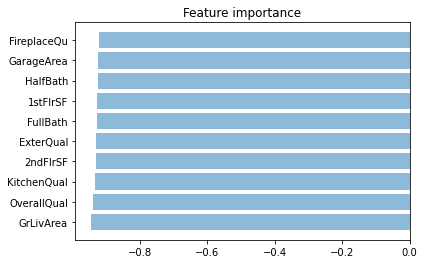

-0.544941246509552


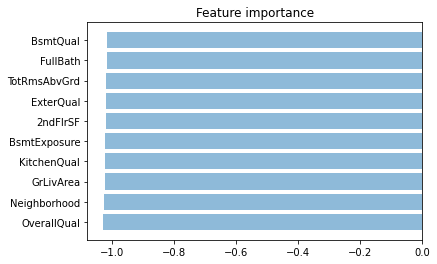

-0.6635215282440186


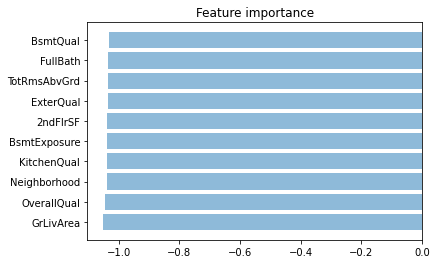

-0.6856832504272461


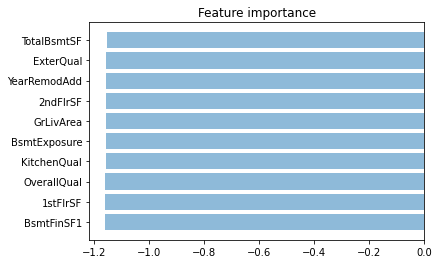

-0.8382750749588013


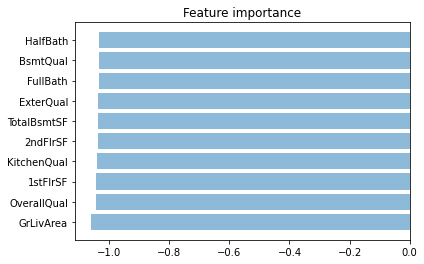

-0.6857665777206421


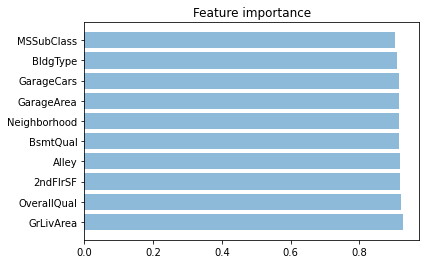

1.748417854309082


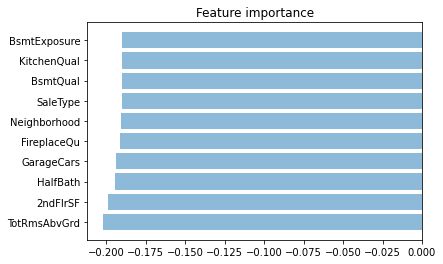

0.4225151836872101


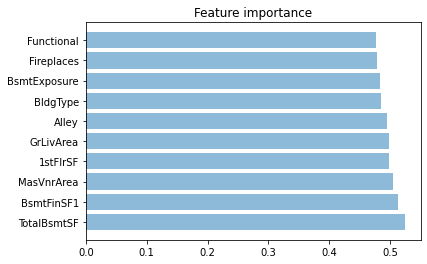

1.2433613538742065


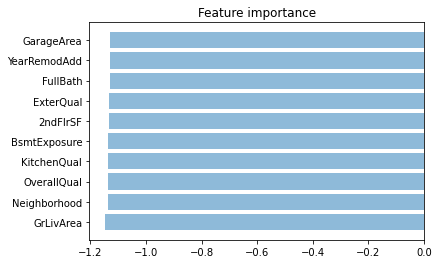

-0.809598445892334


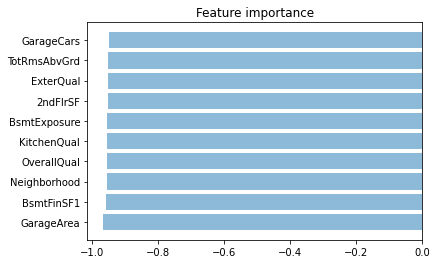

-0.5762510299682617


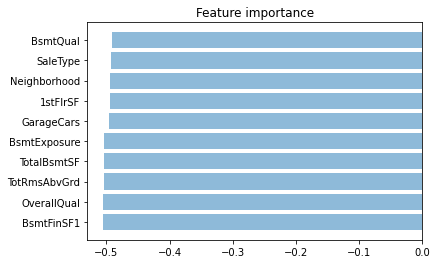

0.022565703839063644


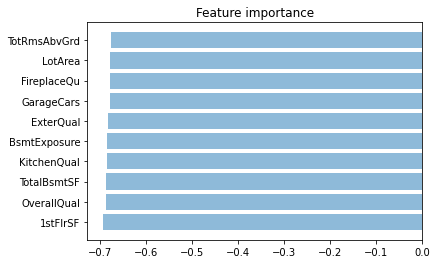

-0.2188871055841446


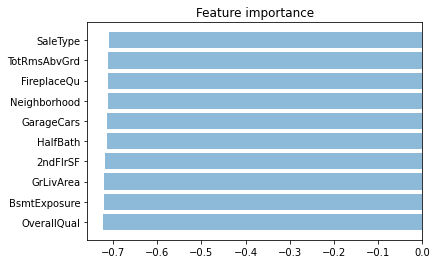

-0.267730176448822


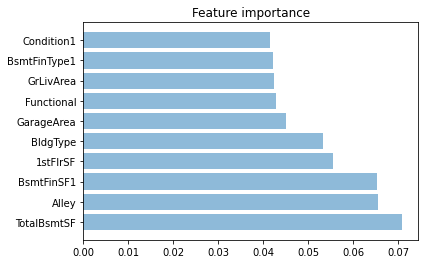

0.6984983086585999


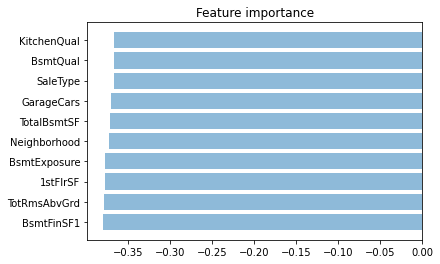

0.18941642343997955


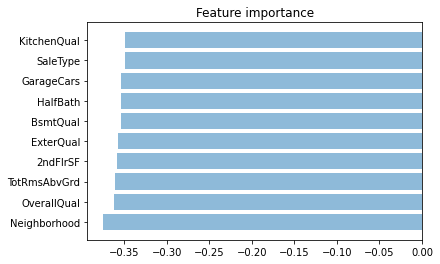

0.21285893023014069


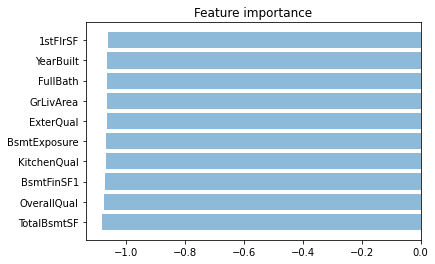

-0.7223135232925415


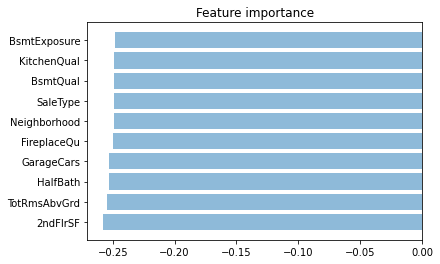

0.34527716040611267


<IPython.core.display.Javascript object>

In [46]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [47]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [48]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

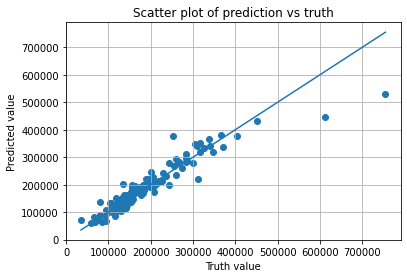

<IPython.core.display.Javascript object>

In [49]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(
    train[target].values[test_indices],
    target_encoder.inverse_transform(probs_test),
)
plt.plot(
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
)
plt.grid(True)
plt.show()

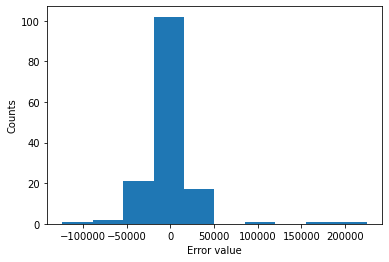

<IPython.core.display.Javascript object>

In [50]:
plt.hist(
    train[target].values[test_indices].reshape(-1)
    - target_encoder.inverse_transform(probs_test).reshape(-1),
)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

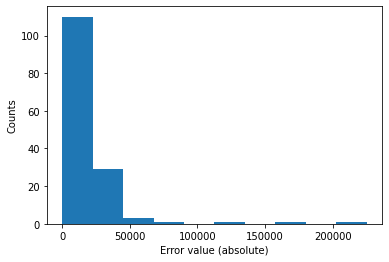

<IPython.core.display.Javascript object>

In [51]:
plt.hist(
    np.abs(
        train[target].values[test_indices].reshape(-1)
        - target_encoder.inverse_transform(probs_test).reshape(-1),
    )
)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()

In [52]:
out = Path(os.getcwd() + "/data/" + dataset_name + "-test.csv")

<IPython.core.display.Javascript object>

In [53]:
kaggle_test = train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [54]:
input_kaggle, _ = preproc_dataset(kaggle_test, target, ["Set"], params)

<IPython.core.display.Javascript object>

In [55]:
probs_kaggle, _ = predict(model, input_kaggle)

<IPython.core.display.Javascript object>

In [56]:
probs_kaggle = target_encoder.inverse_transform(probs_kaggle)

<IPython.core.display.Javascript object>

In [57]:
probs_kaggle

array([[125126.74 ],
       [172765.55 ],
       [201125.   ],
       ...,
       [185594.08 ],
       [123065.664],
       [225210.05 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [58]:
test_df = kaggle_test[["Id"]]

<IPython.core.display.Javascript object>

In [59]:
test_df["SalePrice"] = probs_kaggle

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [60]:
test_df.to_csv("kaggle_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [61]:
# Scores on kaggle
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
# 0.18047
# Batch size 16 + standard scaler
# 0.16028
# batch size 8
# 0.15498

# Should train with RMSLE ?
# from tensorflow.keras import backend as K

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

<IPython.core.display.Javascript object>